# Introduction

This notebook delves into the temporal interaction between variables, calculating temporal causal interactions using Temporal Autoencoders for Causal Inference (TACI). For those interested in exploring static-in-time interactions, please refer to the static_data_tutorial notebook.

This notebook provides a detailed tutorial on training models with TACI to infer causal relationships over time and evaluates these models using various techniques, including bootstrapping. 

The data used in this tutorial predominantly consists of real-world datasets, highlighting practical applications and the effectiveness of TACI in uncovering temporal causal dynamics. Our objective is to reproduce and gain insights into key findings from the associated research paper, focusing on the influence of different system parameters and their interactions on the temporal causal inference process.


In [9]:
# Necessary Imports
import os, re, json, time, pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import tensorflow as tf
from tcn import tcn

from data.dynamic_synthetic.Henon_pulses import on_off_alternating
from data.dynamic_synthetic.Henon_pulses import plot_henon_pulses
from utilities.utils import create_model_parameters
from temporal_synthetic_data import temporal_unidirectional_handler, temporal_unidirectional_model_boot_plot
from temporal_synthetic_data import temporal_bidirectional_handler, temporal_bidirectional_model_boot_plot

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # Suppress TensorFlow logging messages below 'ERROR' level 1
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Set the specific GPU device to be used by CUDA (in this case, GPU device with ID 0)

# Examples Synthetic Data 

## Henon On Off Alternating Pulses

In this section, we generate synthetic data using the causal interaction between two Henon maps with temporal coupling. The Henon map is a well-known discrete-time dynamical system that exhibits chaotic behavior. The Henon maps are defined by:

\begin{equation}
\begin{aligned}
{x_1(t+1)} &= 1.4 - \left(Cx_1(t)x_2(t) + (1-C)x_1^2(t)\right) + 0.3x_2(t) \\
{x_2(t+1)} &= x_1(t) \\
{y_1(t+1)} &= 1.4 - \left(Cy_1(t)y_2(t) + (1-C)y_1^2(t)\right) + 0.3y_2(t) \\
{y_2(t+1)} &= y_1(t) \\
\end{aligned}
\end{equation}

The generated data involves two Henon maps with a predefined value of coupling \( C \). In this setup, the coupling parameters \( C_x \) and \( C_y \) alternate based on a pulse function, which generates an on-off-on pattern. This method allows us to explore how the system behaves under varying coupling conditions.



########################### ON_OFF_Alternating ###########################


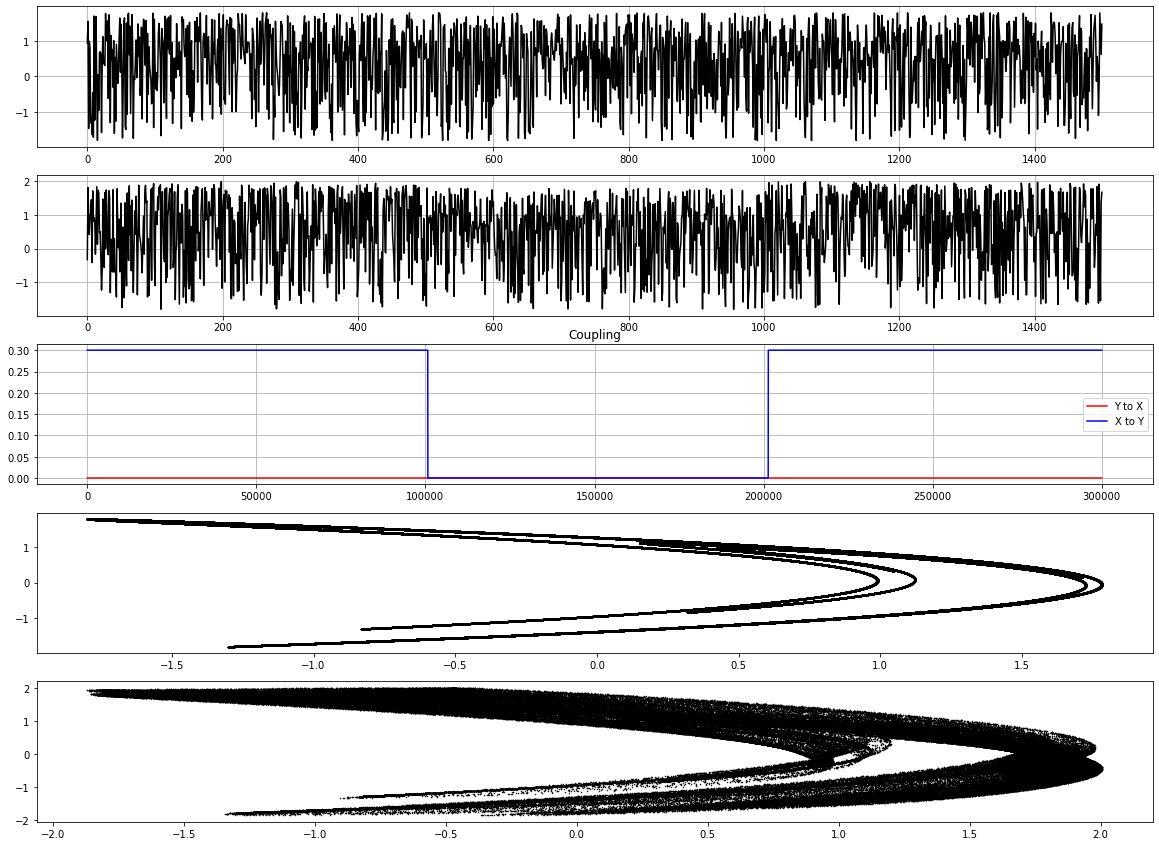

In [4]:
# Generate Variables

var1 = 0
var2 = 2
length_vars = 330000
discard = 30000
init_cond = [0.7, 0, 0.7, 0]
coupling_constant = 0.3001
skip_plot = 200

print('')
print('########################### ON_OFF_Alternating ###########################')
variables, couplingx, couplingy = on_off_alternating(length_vars, discard, 
                                                coupling_constant, init_cond)

plot_henon_pulses(variables, couplingx, couplingy, var1, var2, discard, skip_plot)

### Model Parameters

This section outlines the key parameters that control our model and data generation process. While some parameters are fixed to ensure model stability and consistency, you can adjust others to explore how they influence the model's performance.

#### Adjustable Parameters
- **`length_vars`**: The total number of data points generated for each run of the simulation. Increasing this number provides more data, which could enhance the model's ability to learn but also increases computational demands.
- **`discard`**: The number of initial data points to discard. This is used to remove the transient effects from the beginning of the simulation, ensuring the data reflects the stable behavior of the system.
- **`epochs`**: The number of times the entire dataset is passed forward and backward through the neural network. More epochs can lead to better learning but also risks overfitting if not monitored with validation data.
- **`encoder_type`**: Determines the method of data handling before feeding into the neural network. Set to `1` to include surrogate data, which is helpful for understanding model sensitivity to noise and testing robustness. Set to `2` for random data input, which tests the model’s ability to handle unexpected variations.

#### Fixed Parameters
- **Other Parameters**: Such as `batch_size`, `noise`, and `scaling_method` are set to default values optimized for typical use cases in our studies.


In [5]:
create_new_parameters_for_training = True

version = 1
models_folder = './logs/dynamic_synthetic/On_Off_Alternating/'
encoder_type = 2
tol_default = 0.05
print_out = False

if create_new_parameters_for_training:
    
    model_parameters = create_model_parameters()

    # Define Henon Maps Specific Parameters
    model_parameters['model'] = None
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
    model_parameters['method'] = None
    model_parameters['length_vars'] = 330000
    model_parameters['discard'] = 30000
    model_parameters['init_cond'] = [0.7, 0, 0.7, 0]
    model_parameters['var1'] = 0
    model_parameters['var2'] = 2    
    model_parameters['seq_length'] = 10
    model_parameters['shift'] = 10
    model_parameters['lag'] = 10
    model_parameters['scaling_method'] = 'Standard'
    model_parameters['encoder_type'] = encoder_type
    model_parameters['noise'] = 0.0
    model_parameters['dropout_rate_tcn'] = 0.0
    model_parameters['dropout_rate_hidden'] = 0.0
    model_parameters['tol_default'] = tol_default
    model_parameters['coupling_constant'] = 0.3901
    model_parameters['batch_size'] = 512
    model_parameters['epochs'] = 100
    model_parameters['bootstraps_samples'] = 50
    model_parameters['verbose'] = True  # Enable verbose logging for model training and evaluation processes
    model_parameters['window_len'] = 1200
    
    # Save Parameters
    if not os.path.exists(model_parameters['directory']):
        os.makedirs(model_parameters['directory'])

    dicname = model_parameters['directory'] + 'parameters.json'
    with open(dicname, 'w') as f:
        json.dump(model_parameters, f, indent=4)

    dicname = model_parameters['directory'] + 'parameters.txt'
    with open(dicname, 'w') as f: 
        for key, value in model_parameters.items(): 
            f.write('%s:%s\n' % (key, value))
    
    if print_out:
        print(model_parameters)
    
    variables, couplingx, couplingy = on_off_alternating(model_parameters['length_vars'], 
                                                model_parameters['discard'], 
                                                model_parameters['coupling_constant'], 
                                                model_parameters['init_cond'])
    

### Train Model


Loading Scores ... 



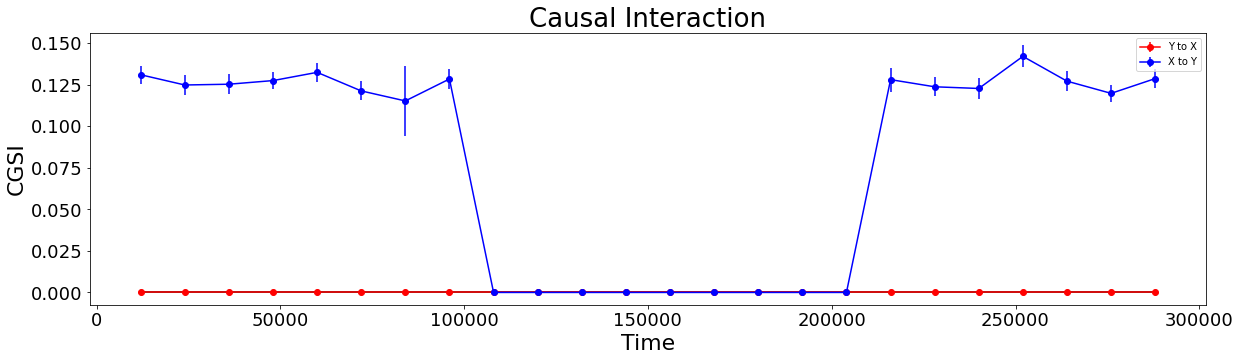



 Elapsed Time : 1.5417447090148926


In [6]:
start = time.time()

train_model = True

if train_model:
    temporal_bidirectional_handler(model_parameters, variables)
else: # Reload Saved Parameters 
    model_parameters={}
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
    parameters_dir = model_parameters['directory'] + 'parameters.json'

    with open(parameters_dir, 'r') as f:
        model_parameters = json.load(f)
        
    variables, couplingx, couplingy = on_off_alternating(model_parameters['length_vars'], 
                                                model_parameters['discard'], 
                                                model_parameters['coupling_constant'], 
                                                model_parameters['init_cond'])
    
model_parameters['paint_fig'] = True
temporal_bidirectional_model_boot_plot(model_parameters, variables)

end = time.time()
print('\n\n Elapsed Time : ' + str(end - start))


# Examples Real Data 

## Jena Climate Data

In this section, we will test our model on real-world data. The first dataset we will explore is the “Jena Climate Dataset”, which is a comprehensive collection of weather measurements recorded by the Max Planck Institute for Biogeochemistry from a weather station located in Jena, Germany (Baligh Mnassri. Jena climate dataset. https://www.bgc-jena.mpg.de/wetter/, 2019).

This dataset spans nearly eight years, from January 10, 2009, to December 31, 2016, and includes 14 distinct meteorological features recorded every 10 minutes. These features provide a detailed account of various weather parameters such as temperature, humidity, wind speed, and more.

By analyzing this dataset, we aim to understand how our model performs on real data, particularly in capturing and predicting temporal causal interactions among the different meteorological features. This real-world application serves as a critical test to validate the robustness and accuracy of our Temporal Autoencoders for Causal Inference (TACI) in practical scenarios.

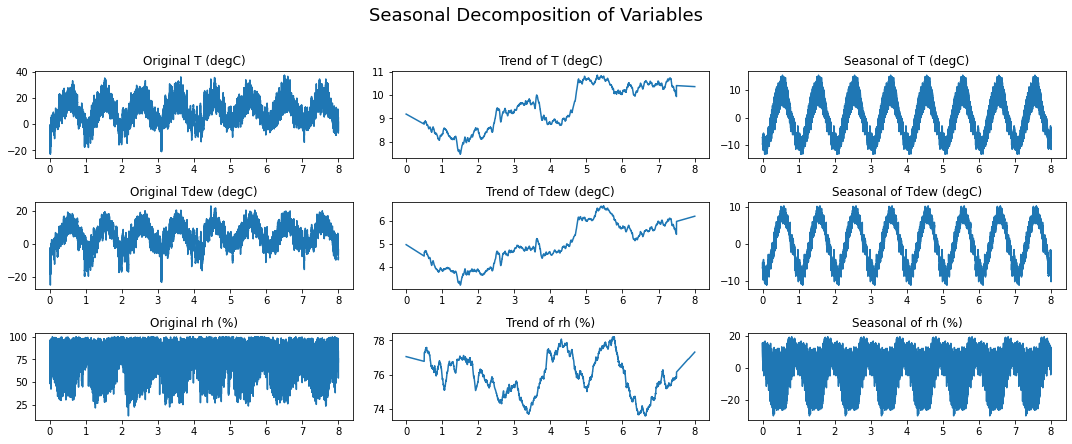

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

filename = './data/real_data/Jena_climate/clean_data.pkl'
with open(filename, "rb") as f:
    data = pickle.load(f)
    
variables_names = data['variable_names']
variables = data['variables']
    
    
fig, axs = plt.subplots(nrows=len(variables_names) - 1, ncols=3, 
                        figsize=(15, 2 * (len(variables_names) - 1)))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Seasonal Decomposition of Variables', fontsize=18, y=1.02)

# Define the period for a common year
period = 52560  # Adjust if you have leap years

for i, var in enumerate(variables_names[1:]):  # Start from the second variable
    
    # Perform seasonal decomposition
    result = seasonal_decompose(variables[:,i+1], 
                period=period, model='additive', extrapolate_trend='freq')

    # Plot the original data
    axs[i, 0].plot(variables[:,0], variables[:,i+1])
    axs[i, 0].set_title(f'Original {var}')

    # Plot the trend component
    axs[i, 1].plot(variables[:,0], result.trend)
    axs[i, 1].set_title(f'Trend of {var}')

    # Plot the seasonal component
    axs[i, 2].plot(variables[:,0], result.seasonal)
    axs[i, 2].set_title(f'Seasonal of {var}')

plt.tight_layout()
plt.show()

variables_names = [name.split(' ')[0].upper() for name in variables_names]


### Model Parameters

This section outlines the key parameters that control our model and data processing approach.

#### Adjustable Parameters
- **`noise`**: The level of noise added to the neural network during training. Adjusting this parameter can help test the model's robustness and ability to handle noisy data.
- **`dropout_rate_tcn`**: The dropout rate for the Temporal Convolutional Network (TCN) layers. This parameter helps prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training time.
- **`dropout_rate_hidden`**: The dropout rate for the hidden layers. Similar to `dropout_rate_tcn`, it helps improve generalization by reducing overfitting.
- **`epochs`**: The number of times the entire dataset is passed forward and backward through the neural network. More epochs can lead to better learning but also risk overfitting if not monitored with validation data.
- **`seq_length`**: The length of the input sequences for the model. Adjusting this parameter can affect the model's ability to capture temporal dependencies in the data.
- **`window_len`**: The length of the window used during the prediction phase to segment the data into chunks for the bootstrapping process. This parameter controls the temporal resolution and affects the amount of contextual information available for predictions.

#### Fixed Parameters
- **Other Parameters**: Such as `batch_size`, `loss_funct`, and `scaling_method` are set to default values optimized for typical use cases in our studies.


In [61]:
create_new_parameters_for_training = True

version = 1
models_folder = './logs/real_data/Jena_climate/'
encoder_type = 2
tol_default = 0.01
print_out = False

if create_new_parameters_for_training:
    
    model_parameters = create_model_parameters()

    # Define Henon Maps Specific Parameters
    model_parameters['model'] = None
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
    model_parameters['method'] = None
    model_parameters['length_vars'] = len(variables)
    model_parameters['discard'] = None
    model_parameters['init_cond'] = None
    model_parameters['var1'] = None
    model_parameters['var2'] = None  
    model_parameters['seq_length'] = 100
    model_parameters['shift'] = 100
    model_parameters['lag'] = 100
    model_parameters['scaling_method'] = 'Standard'
    model_parameters['encoder_type'] = encoder_type
    model_parameters['noise'] = 0.0
    model_parameters['dropout_rate_tcn'] = 0.0
    model_parameters['dropout_rate_hidden'] = 0.0
    model_parameters['tol_default'] = tol_default
    model_parameters['coupling_constant'] = None
    model_parameters['batch_size'] = 512
    model_parameters['epochs'] = 100
    model_parameters['bootstraps_samples'] = 50
    model_parameters['verbose'] = True  # Enable verbose logging for model training and evaluation processes
    model_parameters['window_len'] = 50
    
    # Save Parameters
    if not os.path.exists(model_parameters['directory']):
        os.makedirs(model_parameters['directory'])

    dicname = model_parameters['directory'] + 'parameters.json'
    with open(dicname, 'w') as f:
        json.dump(model_parameters, f, indent=4)

    dicname = model_parameters['directory'] + 'parameters.txt'
    with open(dicname, 'w') as f: 
        for key, value in model_parameters.items(): 
            f.write('%s:%s\n' % (key, value))
    
    if print_out:
        print(model_parameters)
    

### Train Model

In this example, we demonstrate how to use Temporal Autoencoders for Causal Inference (TACI) to analyze uni-directional interactions between variables. Specifically, we will examine the causal influence of each variable on a target variable, allowing us to understand how information flows from one variable to another.


In [ ]:
start = time.time()

train_model = True

for var1 in range(1, variables.shape[1]):
    model_parameters['var1'] = var1
    model_parameters['var2'] = 3   
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/' + \
                                    variables_names[model_parameters['var1']] + '/' + \
                                    variables_names[model_parameters['var2']] + '/'
    if train_model:
        temporal_unidirectional_handler(model_parameters, variables)
    else: # Reload Saved Parameters 
        model_parameters={}
        model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
        parameters_dir = model_parameters['directory'] + 'parameters.json'

        with open(parameters_dir, 'r') as f:
            model_parameters = json.load(f)
    
    temporal_unidirectional_model_boot_plot(model_parameters, variables)

end = time.time()
print('\n\n Elapsed Time : ' + str(end - start))


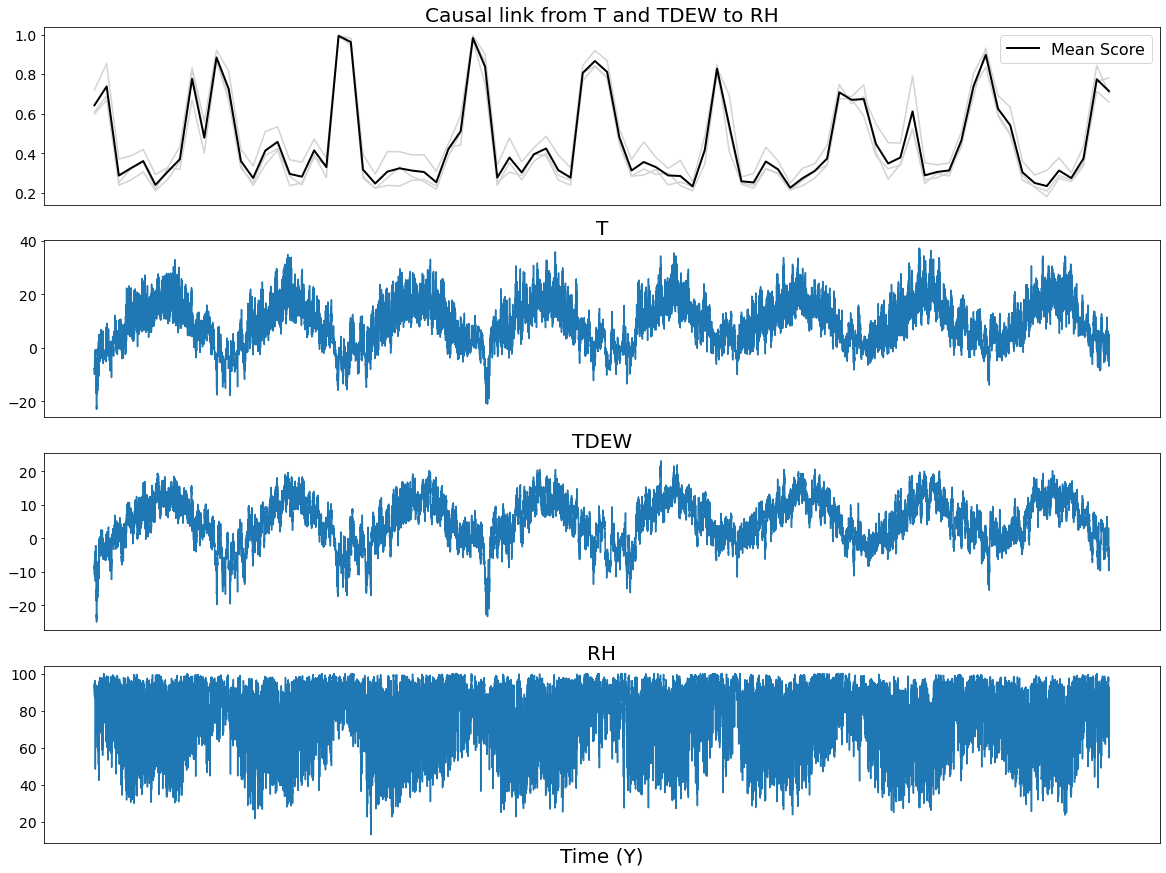

In [56]:
# Define parameters
version = 1
models_folder = './logs/real_data/Jena_climate/'
model_parameters['directory'] = f"{models_folder}Version_{version}/"
parameters_dir = f"{model_parameters['directory']}parameters.json"
encoder_type = model_parameters['encoder_type']

# Set encoder type name
encoder_type_name_map = {
    0: 'Padded_Encoder',
    1: 'Shuffle_encoder',
    2: 'Random_Encoder'
}
encoder_type_name = encoder_type_name_map.get(encoder_type)

# Initialize scores list
scores = []

# Iterate over variables
for var1 in range(1, variables.shape[1]):
    model_parameters['var1'] = var1
    model_parameters['var2'] = 3
    directory_load = (
        f"{models_folder}Version_{version}/"
        f"{variables_names[model_parameters['var1']]}/"
        f"{variables_names[model_parameters['var2']]}/"
        f"{encoder_type_name}/Noise_{model_parameters['noise']}/"
        f"Epochs_{model_parameters['epochs']}/"
        f"SeqLen_{model_parameters['seq_length']}_Shift_{model_parameters['shift']}_Lag_{model_parameters['lag']}/"
        f"Tolerance_{model_parameters['tol_default']}/"
        f"window_length_{model_parameters['window_len']}/"
    )
    
    # Load intervals and scores
    intervals = np.load(f"{directory_load}intervals.npy").astype(int)
    score_boot_mean = np.load(f"{directory_load}score_boot_mean.npy")
    scores.append(score_boot_mean)

# Convert scores to numpy array and calculate mean scores
scores = np.array(scores)
mean_scores = np.mean(scores, axis=0)

# Plotting
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20, 15))
plt.subplots_adjust(hspace=0.2)
axs = axs.flatten()

# Plot individual and mean scores
for ii in range(scores.shape[0]):
    axs[0].plot(variables[intervals, 0], scores[ii, :], color='lightgrey')
axs[0].plot(variables[intervals, 0], mean_scores, color='black', linewidth=2, label='Mean Score')
axs[0].set_xticks([])
axs[0].set_title(f'Causal link from T and TDEW to {variables_names[model_parameters["var2"]]}', fontsize=20)
axs[0].legend(loc='upper right', fontsize=16)
axs[0].tick_params(labelsize=14)

# Plot variables
variables_titles = ['T', 'TDEW', variables_names[model_parameters['var2']]]
for i, (ax, var_idx) in enumerate(zip(axs[1:], [1, 2, model_parameters['var2']])):
    ax.plot(variables[:, 0], variables[:, var_idx])
    ax.set_title(variables_titles[i], fontsize=20)
    ax.set_xticks([])
    ax.tick_params(labelsize=14)
    
axs[3].set_xlabel("Time (Y)", fontsize=20)
axs[3].tick_params(labelsize=14)

plt.show()


## Primate Electrocorticography (ECoG) Data


In this section, we analyze publicly available ECoG data from a single monkey (Macaca fuscata)【Toru Yanagawa, Zenas C. Chao, Naomi Hasegawa, and Naotaka Fujii. "Large-scale information flow in conscious and unconscious states: an ECoG study in monkeys." PLOS ONE, 8(11), 2013. URL: [https://doi.org/10.1371/journal.pone.0080845](https://doi.org/10.1371/journal.pone.0080845)】. These recordings consisted of 128 channels of data that captured activity from a hemisphere of the monkey’s brain, covering the visual, temporal, parietal, motor, prefrontal, and somatosensory cortices. The data was sampled at 1 kHz.

The recordings were collected during both awake and anesthetized states to examine neural activity across different levels of consciousness. The recording sessions were structured into four distinct phases:

1. **Initial Phase**: The monkey is awake with its eyes open.
2. **Eyes Covered Phase**: The monkey is awake but with its eyes covered.
3. **Anesthesia Phase**: The monkey is under deep anesthesia, reaching a state of loss of consciousness.
4. **Recovery Phase**: The monkey recovers from anesthesia with its eyes covered.

By analyzing these distinct phases, we aim to understand how neural activity and information flow differ across varying states of consciousness.


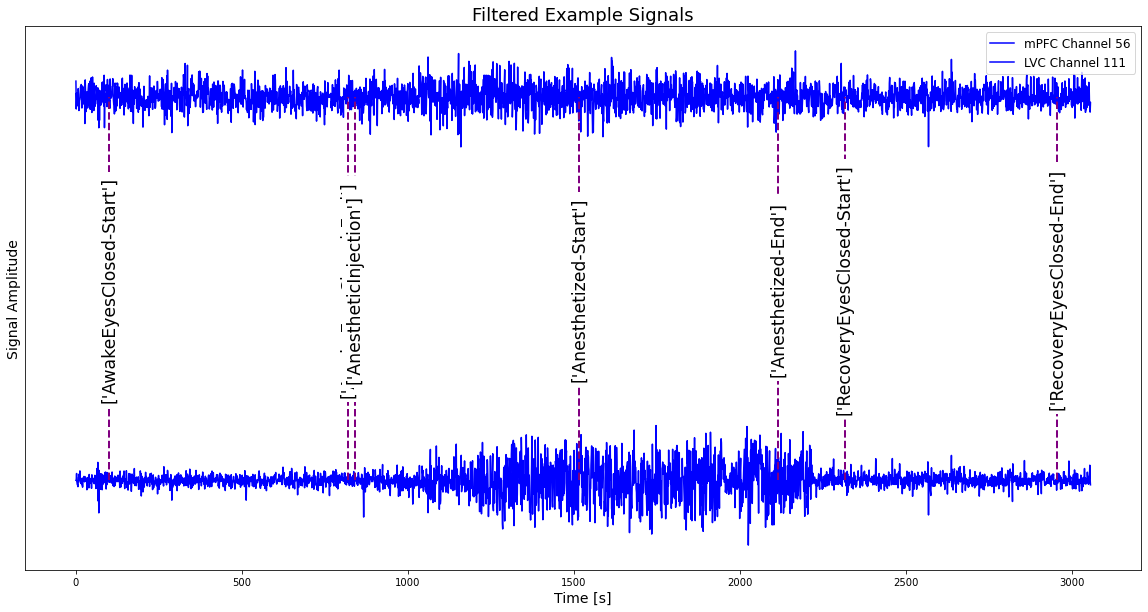

In [100]:
# Load Data    
models_folder = './data/real_data/Primate_ECoG/'
filename = models_folder + 'data.npy'
variables = np.load(filename)
filename = models_folder + 'condition_index.npy'
condition_index = np.load(filename)
filename = models_folder + 'condition_label.pkl'
with open(filename, "rb") as f:
    condition_label = pickle.load(f)
    
skip = 1000

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(variables[::skip, 0], '-b', label=f'mPFC Channel {56}' )
ax.plot(variables[::skip, 1]+8000, '-b', label=f'LVC Channel {111}' )
for kk in range(len(condition_index)):
    ax.vlines(x=condition_index[kk]/1000, ymin=0, ymax=8000, colors='purple', ls='--', lw=2)
    ax.text(x=condition_index[kk]/1000, y=4000, s=condition_label[kk], fontsize='xx-large', ha='center',
             va='center', rotation='vertical', backgroundcolor='white')

ax.legend(loc='upper right', fontsize='large', frameon=True)

# Labels and title
ax.set_xlabel('Time [s]', fontsize=14)
ax.set_ylabel('Signal Amplitude', fontsize=14)
ax.set_yticks([])
ax.set_title('Filtered Example Signals', fontsize=18)

plt.show()

### Model Parameters

This section outlines the key parameters that control our model and data processing approach.

#### Adjustable Parameters
- **`noise`**: The level of noise added to the neural network during training. Adjusting this parameter can help test the model's robustness and ability to handle noisy data.
- **`dropout_rate_tcn`**: The dropout rate for the Temporal Convolutional Network (TCN) layers. This parameter helps prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training time.
- **`dropout_rate_hidden`**: The dropout rate for the hidden layers. Similar to `dropout_rate_tcn`, it helps improve generalization by reducing overfitting.
- **`epochs`**: The number of times the entire dataset is passed forward and backward through the neural network. More epochs can lead to better learning but also risk overfitting if not monitored with validation data.
- **`seq_length`**: The length of the input sequences for the model. Adjusting this parameter can affect the model's ability to capture temporal dependencies in the data.
- **`window_len`**: The length of the window used during the prediction phase to segment the data into chunks for the bootstrapping process. This parameter controls the temporal resolution and affects the amount of contextual information available for predictions.

#### Fixed Parameters
- **Other Parameters**: Such as `batch_size`, `loss_funct`, and `scaling_method` are set to default values optimized for typical use cases in our studies.


In [101]:
create_new_parameters_for_training = True

version = 1
models_folder = './logs/real_data/Primate_ECoG/'
encoder_type = 2
tol_default = 0.01
print_out = False

if create_new_parameters_for_training:
    
    model_parameters = create_model_parameters()

    # Define Henon Maps Specific Parameters
    model_parameters['model'] = None
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
    model_parameters['method'] = None
    model_parameters['length_vars'] = len(variables)
    model_parameters['discard'] = None
    model_parameters['init_cond'] = None
    model_parameters['var1'] = 0
    model_parameters['var2'] = 1  
    model_parameters['seq_length'] = 50
    model_parameters['shift'] = 50
    model_parameters['lag'] = 50
    model_parameters['scaling_method'] = 'Standard'
    model_parameters['encoder_type'] = encoder_type
    model_parameters['noise'] = 0.0
    model_parameters['dropout_rate_tcn'] = 0.0
    model_parameters['dropout_rate_hidden'] = 0.0
    model_parameters['tol_default'] = tol_default
    model_parameters['coupling_constant'] = None
    model_parameters['batch_size'] = 512
    model_parameters['epochs'] = 100
    model_parameters['bootstraps_samples'] = 50
    model_parameters['verbose'] = True  # Enable verbose logging for model training and evaluation processes
    model_parameters['window_len'] = 2000
    
    # Save Parameters
    if not os.path.exists(model_parameters['directory']):
        os.makedirs(model_parameters['directory'])

    dicname = model_parameters['directory'] + 'parameters.json'
    with open(dicname, 'w') as f:
        json.dump(model_parameters, f, indent=4)

    dicname = model_parameters['directory'] + 'parameters.txt'
    with open(dicname, 'w') as f: 
        for key, value in model_parameters.items(): 
            f.write('%s:%s\n' % (key, value))
    
    if print_out:
        print(model_parameters)
    

In [ ]:
start = time.time()

train_model = True

if train_model:
    temporal_bidirectional_handler(model_parameters, variables)
else: # Reload Saved Parameters 
    model_parameters={}
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
    parameters_dir = model_parameters['directory'] + 'parameters.json'

    with open(parameters_dir, 'r') as f:
        model_parameters = json.load(f)
            
temporal_bidirectional_model_boot_plot(model_parameters, variables)

end = time.time()
print('\n\n Elapsed Time : ' + str(end - start))


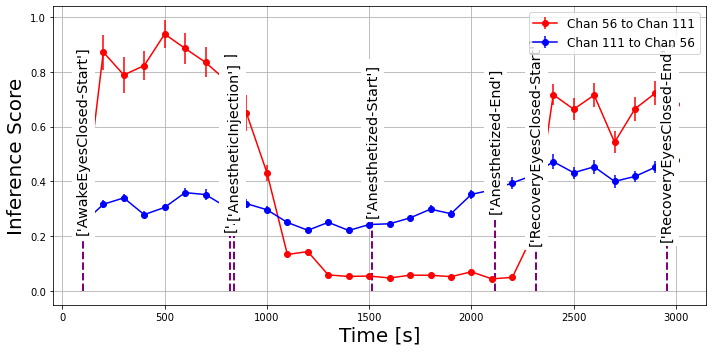

In [113]:
# Define parameters
version = 1
models_folder = './logs/real_data/Primate_ECoG/'
model_parameters['directory'] = f"{models_folder}Version_{version}/"
parameters_dir = f"{model_parameters['directory']}parameters.json"
encoder_type = model_parameters['encoder_type']

# Set encoder type name
encoder_type_name_map = {
    0: 'Padded_Encoder',
    1: 'Shuffle_encoder',
    2: 'Random_Encoder'
}
encoder_type_name = encoder_type_name_map.get(encoder_type)

directory_load = (
    f"{models_folder}Version_{version}/"
    f"{encoder_type_name}/Noise_{model_parameters['noise']}/"
    f"Epochs_{model_parameters['epochs']}/"
    f"SeqLen_{model_parameters['seq_length']}_Shift_{model_parameters['shift']}_Lag_{model_parameters['lag']}/"
    f"Tolerance_{model_parameters['tol_default']}/"
    f"window_length_{model_parameters['window_len']}/"
)

# Load intervals and scores
intervals = np.load(f"{directory_load}intervals.npy").astype(int)
score_boot_mean = np.load(f"{directory_load}score_boot_mean.npy")
score_boot_std = np.load(f"{directory_load}score_boot_std.npy")

fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the error bars
ax.errorbar(intervals / 1000, score_boot_mean[0], yerr=score_boot_std[0],
            fmt='o-', color='red', label='Chan 56 to Chan 111')
ax.errorbar(intervals / 1000, score_boot_mean[1], yerr=score_boot_std[1],
            fmt='o-', color='blue', label='Chan 111 to Chan 56')

# Adding vertical lines and labels for conditions
for kk in range(len(condition_index)):
    ax.vlines(x=condition_index[kk] / 1000, ymin=0, ymax=0.5, colors='purple', ls='--', lw=2)
    ax.text(x=condition_index[kk] / 1000, y=0.55, s=condition_label[kk], fontsize='x-large',
            ha='center', va='center', rotation='vertical', backgroundcolor='white')

# Adding legend
ax.legend(loc='upper right', fontsize='large', frameon=True)

# Labels and title
ax.set_xlabel('Time [s]', fontsize=20)
ax.set_ylabel('Inference Score', fontsize=20)
# ax.set_title('Inference Scores Over Time', fontsize=14)

# Adding grid
ax.grid(True)

# Adjusting layout
plt.tight_layout()

plt.show()


